In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import folium 
import matplotlib
import matplotlib.pyplot as plt
import seaborn as seabornInstance 

#Display charts in the notebook
%matplotlib inline

#Stats model to get p-values
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.iolib.summary2 import summary_col



#SciKit Learn a python ML Library
from sklearn.preprocessing import RobustScaler, Imputer, PolynomialFeatures, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, cross_val_predict
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score
from sklearn.pipeline import make_pipeline

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor

#SciKit Feature selection
from sklearn.svm import LinearSVC
from sklearn.model_selection import StratifiedKFold, KFold, LeaveOneOut
from sklearn.feature_selection import RFECV

In [2]:
#import the previous made main df
master_df = pd.read_csv("../mapping_stage/census/master_df_w_census.csv")
master_df.rename(columns={'90pctle_citedby': 'pctle_citedby'}, inplace=True)
master_df.head()

,STCOU,Area_name,patent_output,grad_pat_output,total_cited_by,mean_cit_pp,pctle_citedby,total_pop,pop_psqm,area_sqm,pct_2races,high_education,mortgaged,working_age,high_earners
0,6085,"Santa Clara, CA",13755,-19.178571,28775,2.091967,5.0,1781642.0,1381.0,1304.01,4.9,215568.0,270364.0,661052.0,136873.0
1,6037,"Los Angeles, CA",5907,2.202381,10176,1.722702,4.0,9818605.0,2419.6,4752.32,4.5,608186.0,1196174.0,3658845.0,354019.0
2,6073,"San Diego, CA",5445,6.607143,9663,1.774656,4.0,3095313.0,735.8,4525.52,5.1,244099.0,458225.0,1162235.0,133057.0
3,53033,"King, WA",4325,10.011905,9820,2.270520,6.0,1931249.0,912.9,2306.53,5.0,208097.0,361750.0,739329.0,107496.0
4,6059,"Orange, CA",4007,1.750000,9045,2.257300,5.0,3010232.0,3807.7,947.98,4.2,237180.0,464666.0,1066172.0,168995.0


# Displaying Correlation 
This section will display the correlation matrix for normalised and unormalised indepentend variables.

In [3]:
#SomeOOP, has multiple functions displaying the methods we would like to use
class CorrelationAnalysis:
    '''This class provides correlation information for dataframe objects
    type(df) = dataframe
    type(name) = string'''
    
    def __init__(self, df, name):
        self.__df = df
        self.__name = name
        
    def corrmatOutput(self):
        '''Correlation Matrix Heatmap'''
        df = self.__df
        self.corrmat = df.corr(method ='spearman')
        f, ax = plt.subplots(figsize=(12, 9))
        sns.heatmap(self.corrmat, vmax=.8, square=True,cmap="YlGnBu");
        plt.title(f'Correlation Matrix For {self.__name}')
    
    def topCorrelated(self, num):
        '''Prints the highest correlated pairs
        type(num) =  int'''
        s = self.corrmat.unstack()
        so = s.sort_values(kind="quicksort", ascending=False).drop_duplicates()
        print(so.nlargest(num))
    
    def plotCorrelation(self, x_axis, y_axis):
        '''Produces a joint plot for two columns
        type(x_axis, y_axis) + str'''
        sns.jointplot(x=self.__df[f'{x_axis}'], y=self.__df[f'{y_axis}'], kind='reg')

## Percentage of Population
Now the correlations are normalised by the total population

In [4]:
pd.options.mode.chained_assignment = None #ignore the copy warning

#Create a copy of the data frame to normalise the independent variables
pct_df =  master_df[['patent_output', 'grad_pat_output', 
                           'total_cited_by', 'mean_cit_pp', 'pctle_citedby', 
                           'total_pop', 'area_sqm',
                           'high_education', 'mortgaged', 'working_age', 'high_earners']]

#perfrom the normalisation
#patent ouput div by the population
#pct_df['patent_output_pp'] = (pct_df['patent_output']/pct_df['total_pop']) 

#div by population and x100 to see percentage
pct_df['pct_high_education'] = (pct_df['high_education']/pct_df['total_pop'])*100
pct_df['pct_mortgaged'] = (pct_df['mortgaged']/pct_df['total_pop'])*100
pct_df['pct_working_age'] = (pct_df['working_age']/pct_df['total_pop'])*100
pct_df['pct_high_earners'] = (pct_df['high_earners']/pct_df['total_pop'])*100

#drop the unormalised columns
pct_df.drop(['high_education', 'mortgaged',
             'working_age', 'high_earners'], axis=1, inplace=True)

pct_df.head()

,patent_output,grad_pat_output,total_cited_by,mean_cit_pp,pctle_citedby,total_pop,area_sqm,pct_high_education,pct_mortgaged,pct_working_age,pct_high_earners
0,13755,-19.178571,28775,2.091967,5.0,1781642.0,1304.01,12.099400,15.174990,37.103526,7.682408
1,5907,2.202381,10176,1.722702,4.0,9818605.0,4752.32,6.194220,12.182729,37.264408,3.605594
2,5445,6.607143,9663,1.774656,4.0,3095313.0,4525.52,7.886085,14.803834,37.548222,4.298661
3,4325,10.011905,9820,2.270520,6.0,1931249.0,2306.53,10.775255,18.731401,38.282428,5.566139
4,4007,1.750000,9045,2.257300,5.0,3010232.0,947.98,7.879127,15.436219,35.418267,5.614019


pct_high_earners    pct_high_earners      1.000000
pctle_citedby       mean_cit_pp           0.921364
patent_output       total_cited_by        0.878030
total_cited_by      pctle_citedby         0.840657
patent_output       total_pop             0.769746
total_cited_by      mean_cit_pp           0.745770
pct_high_education  pct_high_earners      0.687153
total_pop           total_cited_by        0.675529
pct_high_earners    patent_output         0.612035
pct_high_education  patent_output         0.572028
pctle_citedby       patent_output         0.564822
pct_working_age     total_pop             0.564617
total_cited_by      pct_high_earners      0.537192
total_pop           pct_high_education    0.510611
                    pct_high_earners      0.510089
total_cited_by      pct_high_education    0.508236
pct_high_earners    pct_mortgaged         0.432209
patent_output       pct_working_age       0.394506
mean_cit_pp         patent_output         0.394240
total_pop           pctle_cited

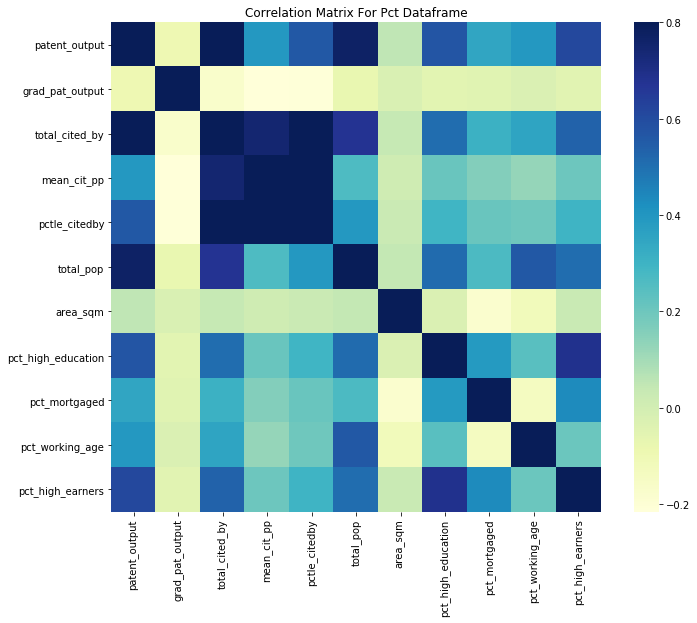

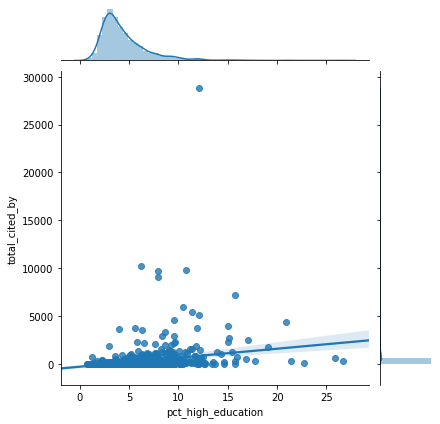

In [5]:
pct_df_corr = CorrelationAnalysis(pct_df, "Pct Dataframe")
pct_df_corr.corrmatOutput()
pct_df_corr.topCorrelated(25)
pct_df_corr.plotCorrelation('pct_high_education', 'total_cited_by')

In [33]:
pd.options.display.float_format = '{:.1f}'.format
desc_var = pct_df[['area_sqm','total_pop', 'pct_high_education', 
                     'pct_mortgaged', 'pct_working_age', 'pct_high_earners']]
desc_stats = desc_var.describe()
print(desc_stats)

       area_sqm  total_pop  pct_high_education  pct_mortgaged  \
count    2356.0     2356.0              2356.0         2356.0   
mean     1098.2   127262.5                 4.5           16.3   
std      1965.2   356689.1                 2.5            3.4   
min         0.0      712.0                 0.7            2.1   
25%       455.8    18208.8                 2.8           14.2   
50%       650.6    39151.5                 3.8           16.5   
75%       978.1    98743.0                 5.4           18.6   
max     45508.5  9818605.0                26.7           30.7   

       pct_working_age  pct_high_earners  
count           2356.0            2356.0  
mean              30.4               1.7  
std                4.5               1.4  
min               17.5               0.0  
25%               27.8               0.9  
50%               30.0               1.3  
75%               32.7               2.0  
max               53.2              11.2  


In [7]:
reg_df = pct_df # percentages calculated
col = ['patent_output', 'grad_pat_output', 'total_cited_by', 'mean_cit_pp', 'pctle_citedby',
       'area_sqm','total_pop', 'pct_high_education', 'pct_mortgaged', 
       'pct_working_age', 'pct_high_earners']

# Building Regression

As we have multiple potential dependent vairables, we must define the one we will use first. This way the code can be repeated with alternate variables. First bwe set up our numpy arrays of target (y) and features (X).

## Data preprocessing
We can see that X does have some NaN values (a very small portion) however we can fill using the median.

In [8]:
#Check if there are any NaN values
print(f'Does data have NaN values: {np.isnan(reg_df).any()}')

sparsity = 1.0 - ( np.count_nonzero(reg_df) / float(reg_df.size) )
print(f'The sparsity for dataframe NaN values is: {sparsity}')

Does data have NaN values: patent_output         False
grad_pat_output        True
total_cited_by        False
mean_cit_pp           False
pctle_citedby         False
total_pop              True
area_sqm               True
pct_high_education     True
pct_mortgaged          True
pct_working_age        True
pct_high_earners       True
dtype: bool
The sparsity for dataframe NaN values is: 0.06797191054118001


In [9]:
reg_df = reg_df.fillna(reg_df.median())
print(f'Does norm_corr_df_new have NaN values: {np.isnan(reg_df).any()}')

Does norm_corr_df_new have NaN values: patent_output         False
grad_pat_output       False
total_cited_by        False
mean_cit_pp           False
pctle_citedby         False
total_pop             False
area_sqm              False
pct_high_education    False
pct_mortgaged         False
pct_working_age       False
pct_high_earners      False
dtype: bool


### Feature Scaling of dataset

The [RobustScaler](http://benalexkeen.com/feature-scaling-with-scikit-learn/) uses a similar method to the Min-Max scaler but it instead uses the interquartile range, rathar than the min-max, so that it is robust to outliers. 

Should we normalise the target variable as well?

In [10]:

scaler = RobustScaler()
robust_scaled_df = scaler.fit_transform(reg_df)
robust_scaled_df = pd.DataFrame(robust_scaled_df, columns=col)

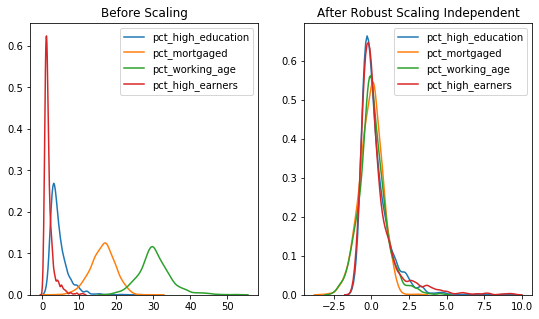

In [11]:


fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(9, 5))

ax1.set_title('Before Scaling')
#sns.kdeplot(norm_corr_df_new['total_pop'], ax=ax1)
sns.kdeplot(reg_df['pct_high_education'], ax=ax1)
sns.kdeplot(reg_df['pct_mortgaged'], ax=ax1)
sns.kdeplot(reg_df['pct_working_age'], ax=ax1)
sns.kdeplot(reg_df['pct_high_earners'], ax=ax1)

ax2.set_title('After Robust Scaling Independent')
#sns.kdeplot(robust_scaled_df['total_pop'], ax=ax2)
sns.kdeplot(robust_scaled_df['pct_high_education'], ax=ax2)
sns.kdeplot(robust_scaled_df['pct_mortgaged'], ax=ax2)
sns.kdeplot(robust_scaled_df['pct_working_age'], ax=ax2)
sns.kdeplot(robust_scaled_df['pct_high_earners'], ax=ax2)

plt.show()

In [12]:
robust_scaled_df.head()

,patent_output,grad_pat_output,total_cited_by,mean_cit_pp,pctle_citedby,area_sqm,total_pop,pct_high_education,pct_mortgaged,pct_working_age,pct_high_earners
0,687.5,-121.2,846.1,0.7,0.9,22.2,1.3,3.4,-0.3,1.5,6.1
1,295.1,13.9,299.1,0.5,0.5,124.5,8.0,1.0,-1.0,1.5,2.2
2,271.9,41.8,284.0,0.5,0.5,38.9,7.6,1.7,-0.4,1.5,2.9
3,215.9,63.3,288.6,0.8,1.2,24.1,3.2,2.8,0.5,1.7,4.1
4,200.1,11.1,265.8,0.8,0.9,37.8,0.6,1.7,-0.2,1.1,4.1


## Regression using statsmodel
At this stage we use the whole data set to see the best predictors. [Sci-kit learn has no p-value functions](https://datascience.stackexchange.com/questions/24405/how-to-do-stepwise-regression-using-sklearn), so instead o f manually writing one, we will use [statsmodel](https://stackoverflow.com/questions/27928275/find-p-value-significance-in-scikit-learn-linearregression) instead. Does not [add_constant](http://geekwentfreak.com/posts/stats/statsmodels_add_constant/) as unsure what it does

In [13]:
y_pat_out = robust_scaled_df['patent_output']
X = robust_scaled_df[['total_pop', 'area_sqm', 'pct_high_education','pct_mortgaged', 'pct_working_age', 'pct_high_earners']]
X = sm.add_constant(X) # Required to make comparable to the satsmodel.method.api

# Using Patent Output as the first example
est = sm.OLS(y_pat_out, X).fit()
print(est.summary())

                            OLS Regression Results                            
Dep. Variable:          patent_output   R-squared:                       0.423
Model:                            OLS   Adj. R-squared:                  0.422
Method:                 Least Squares   F-statistic:                     290.8
Date:                Wed, 14 Aug 2019   Prob (F-statistic):          1.14e-279
Time:                        22:04:02   Log-Likelihood:                -9872.8
No. Observations:                2382   AIC:                         1.976e+04
Df Residuals:                    2375   BIC:                         1.980e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -0.7123      0

/Users/yusufsohoye/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


Printing some more friendly output, for further use, have a look at [this example](https://lectures.quantecon.org/py/ols.html)

The p values seem [satistically significant](https://datatofish.com/statsmodels-linear-regression/). P >|t| is  p-value. A p-value of less than 0.05 is considered to be statistically significant.


## Step-wise
There are no built-in stepwise forward selection functions in statsmodels or sci-kit learn, but you can [write one](https://planspace.org/20150423-forward_selection_with_statsmodels/). For feature selection there are multiple routes:
- Forward stepwise where you start with one variable and add on another each step, which is either kept or dropped based on some criteria (usually a BIC or AIC score). Backwards stepwise regression is the same thing but you start with all variables and remove one each time again based on some criteria. 
- Sci-Kit learn doesnt have an exact method but has a similar one [Recursive Feature Elimination](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html)

In [14]:
def forward_selected(data, response):
    """Linear model designed by forward selection.

    Parameters:
    -----------
    data : pandas DataFrame with all possible predictors and response

    response: string, name of response column in data

    Returns:
    --------
    model: an "optimal" fitted statsmodels linear model
           with an intercept
           selected by forward selection
           evaluated by adjusted R-squared
    """
    remaining = set(data.columns)
    remaining.remove(response)
    selected = []
    current_score, best_new_score = 0.0, 0.0
    while remaining and current_score == best_new_score:
        scores_with_candidates = []
        for candidate in remaining:
            formula = "{} ~ {} + 1".format(response,
                                           ' + '.join(selected + [candidate]))
            score = smf.ols(formula, data).fit().rsquared_adj
            scores_with_candidates.append((score, candidate))
        scores_with_candidates.sort(reverse=False)
        best_new_score, best_candidate = scores_with_candidates.pop()
        if current_score < best_new_score:
            remaining.remove(best_candidate)
            selected.append(best_candidate)
            current_score = best_new_score
    formula = "{} ~ {} + 1".format(response,
                                   ' + '.join(selected))
    model = smf.ols(formula, data).fit()
    return model



In [15]:
cand_dep_var =['patent_output', 'grad_pat_output','total_cited_by', 'mean_cit_pp', 'pctle_citedby']

for dep_var in cand_dep_var:
    data =  robust_scaled_df[[f'{dep_var}','total_pop', 'area_sqm', 'pct_high_education','pct_mortgaged', 'pct_working_age', 'pct_high_earners']]
    model = forward_selected(data, f'{dep_var}')
    print(model.model.formula)
    print(model.rsquared_adj)




patent_output ~ area_sqm + pct_high_earners + pct_mortgaged + pct_working_age + total_pop + 1
0.42212119932332226
grad_pat_output ~ pct_high_earners + pct_high_education + 1
0.021532144830112454
total_cited_by ~ area_sqm + pct_high_earners + pct_mortgaged + pct_working_age + total_pop + 1
0.36338761937355357
mean_cit_pp ~ pct_high_earners + pct_working_age + pct_mortgaged + 1
0.005307362622135714
pctle_citedby ~ pct_high_earners + pct_working_age + pct_mortgaged + area_sqm + 1
0.031059162988090527


In [16]:
y_pat_out = robust_scaled_df['patent_output']
X_pat_out = X[['const','total_pop', 'area_sqm','pct_mortgaged', 'pct_working_age', 'pct_high_earners']]

y_grad_out = robust_scaled_df['grad_pat_output']
X_grad_out = X[['const', 'pct_high_education', 'pct_high_earners']]

y_total_cit = robust_scaled_df['total_cited_by']
X_total_cit =  X[['const','total_pop', 'area_sqm','pct_mortgaged', 'pct_working_age', 'pct_high_earners']]

y_mean_cit = robust_scaled_df['mean_cit_pp']
X_mean_cit = X[['const','pct_mortgaged', 'pct_working_age', 'pct_high_earners']]

y_pct_cit = robust_scaled_df['pctle_citedby']
X_pct_cit = X[['const','area_sqm','pct_mortgaged', 'pct_working_age', 'pct_high_earners']]

In [17]:

#creating a regression for each
pat_output = sm.OLS(y_pat_out, X_pat_out).fit()
grad_output = sm.OLS(y_grad_out, X_grad_out).fit()
total_cited = sm.OLS(y_total_cit, X_total_cit).fit()
mean_cited = sm.OLS(y_mean_cit, X_mean_cit).fit()
pctile_cited = sm.OLS(y_pct_cit, X_pct_cit).fit()

info_dict={'R-squared' : lambda X2: f"{X2.rsquared:.2f}",
           'No. observations' : lambda X2: f"{int(X2.nobs):d}"}

results_table = summary_col(results=[pat_output, grad_output, total_cited, mean_cited, pctile_cited],
            float_format='%0.2f', stars = True, info_dict=info_dict,)


print(results_table)


                   patent_output grad_pat_output total_cited_by mean_cit_pp pctle_citedby
-----------------------------------------------------------------------------------------
area_sqm           2.62***                       2.79***                    0.01         
                   (0.08)                        (0.10)                     (0.01)       
const              -0.69**       -0.19           -0.81*         0.27***     0.22***      
                   (0.34)        (0.12)          (0.43)         (0.03)      (0.03)       
pct_high_earners   2.58***       -0.53***        3.56***        0.04*       0.07***      
                   (0.29)        (0.15)          (0.36)         (0.02)      (0.02)       
pct_high_education               -0.22                                                   
                                 (0.20)                                                  
pct_mortgaged      -1.81***                      -2.42***       0.07*       0.16***      
         

## Prediction
### Training and test data
The dataset is now split into two parts: training set and test set. We use the training set for training a model, and apply the trained model to the test set, in order to evaluate the performance of our model.

In [18]:
# # Citations output_optimal
# y_cit_out = robust_scaled_df['total_cited_by']
# X_opt = robust_scaled_df[['total_pop', 'pct_high_earners', 'area_sqm', 'pct_mortgaged', 'pct_working_age']]
# X_train, X_test, y_train, y_test = train_test_split(X_opt, y_cit_out, test_size=0.5, random_state=0)

# # Set
# cv = KFold(n_splits=10)
# y_pat_out = y_cit_out
# # #LOO cv
# # cv = LeaveOneOut()
# # cv.get_n_splits(X_opt)

In [19]:
# patent output_optimal
y_pat_out = robust_scaled_df['patent_output']
X_opt = robust_scaled_df[['total_pop', 'pct_high_earners', 'area_sqm', 'pct_mortgaged', 'pct_working_age']]
X_train, X_test, y_train, y_test = train_test_split(X_opt, y_pat_out, test_size=0.2, random_state=0)

# Set
cv = KFold(n_splits=5)

# #LOO cv
# cv = LeaveOneOut()
# cv.get_n_splits(X_opt)

### Baseline
Before we start to compute the predictions, it is benificial to have a baseline prediction, we will have 2:
- linear regression using only population
- mean patent value

In [20]:
X_baseline_trian = X_train.values[:,0].reshape(-1, 1) #Only use the population column of training data
X_baseline_test = X_test.values[:,0].reshape(-1, 1) #Only use the population column of test data


lr_baseline = LinearRegression()     # Create sklearn model object  
lr_baseline.fit(X_baseline_trian, y_train)    # Fit model with training data


# Compute Error measures for the TRAIN dataset
y_lr_base_train = lr_baseline.predict(X_baseline_trian)   #Prediction for TEST data
train_mse_lr = mean_squared_error(y_train, y_lr_base_train)  
train_mae_lr = mean_absolute_error(y_train, y_lr_base_train)
print(f'''Baseline LR TRAIN mse: {train_mse_lr}
Baseline LR TRAIN mae: {train_mae_lr}''')

# Compute Error measures for the TEST dataset
y_lr_base_test = lr_baseline.predict(X_baseline_test)   #Prediction for TEST data
# Compute Error measures for the TEST dataset
mse_lr = mean_squared_error(y_test, y_lr_base_test)  
mae_lr = mean_absolute_error(y_test, y_lr_base_test)
print(f'''Baseline LR TEST mse: {mse_lr}
Baseline LR TEST mae: {mae_lr}''')

Baseline LR TRAIN mse: 425.5559701616348
Baseline LR TRAIN mae: 4.889181716060651
Baseline LR TEST mse: 317.62111446349604
Baseline LR TEST mae: 5.338767161207479


In [21]:
train_mean = np.mean(X_baseline_trian) # find the mean of the training data
X_baseline_train_mean = np.empty(len(X_baseline_trian)) #initialise an empty array the same size as the train data
X_baseline_train_mean.fill(train_mean) # fill the array woth the mean value

X_baseline_test_mean= np.empty(len(X_baseline_test))
X_baseline_test_mean.fill(train_mean) # fill the array woth the mean value

# Compute Error measures for the TRAIN dataset
train_mse_lr = mean_squared_error(y_train, X_baseline_train_mean)  
train_mae_lr = mean_absolute_error(y_train, X_baseline_train_mean)
print(f'''Baseline Mean TRAIN mse: {train_mse_lr}
Baseline Mean TRAIN mae: {train_mae_lr}''')

# Compute Error measures for the TEST dataset
mse_lr = mean_squared_error(y_test, X_baseline_test_mean)  
mae_lr = mean_absolute_error(y_test, X_baseline_test_mean)
print(f'''Baseline Mean TEST mse: {mse_lr}
Baseline Mean TEST mae: {mae_lr}''')

Baseline Mean TRAIN mse: 430.446966448187
Baseline Mean TRAIN mae: 3.487097720350788
Baseline Mean TEST mse: 325.8598255450472
Baseline Mean TEST mae: 3.9222914243475517


## Prediction: Linear Regression
This section solves the regression problem with different methods. We also compute mean squared error (MSE) and mean absolute error (MAE) for future use.

In [22]:
# The structure of the code is always the same: Create model object, 
# Fit with training data, predict and compute error.

lr = LinearRegression()     # Create sklearn model object  
lr.fit(X_train, y_train)    # Fit model with training data

coeff_df = pd.DataFrame(lr.coef_, X_opt.columns, columns=['Coefficient'])  
coeff_df

,Coefficient
total_pop,-0.2
pct_high_earners,2.1
area_sqm,3.4
pct_mortgaged,-2.0
pct_working_age,-1.1


In [23]:
# Compute Error measures for the TRAIN dataset
y_lr_train = lr.predict(X_train)   #Prediction for TEST data
train_mse_lr = mean_squared_error(y_train, y_lr_train)  
train_mae_lr = mean_absolute_error(y_train, y_lr_train)
print(f'''TRAIN mse_lr: {train_mse_lr}
TRAIN mae_lr: {train_mae_lr}''')

TRAIN mse_lr: 269.7038209436816
TRAIN mae_lr: 3.9780664746530117


In [24]:
y_lr = lr.predict(X_test)   #Prediction for TEST data

# Compute Error measures for the TEST dataset
mse_lr = mean_squared_error(y_test, y_lr)  
mae_lr = mean_absolute_error(y_test, y_lr)


print(f'''TEST mse_lr: {mse_lr}
TEST mae_lr: {mae_lr}''')

TEST mse_lr: 148.2263148068766
TEST mae_lr: 4.24633928164841


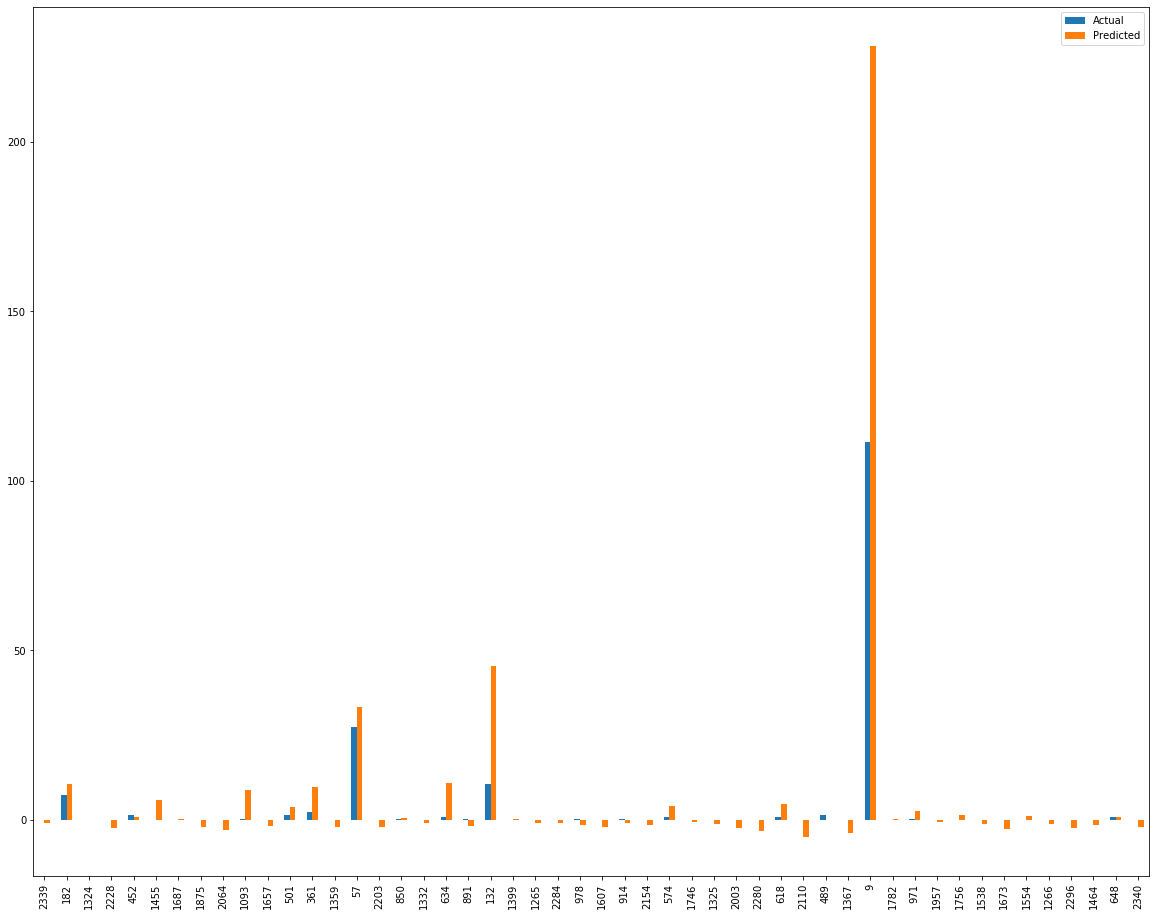

In [25]:
df = pd.DataFrame({'Actual': y_test, 'Predicted': y_lr})
df1 = df.head(50)

df1.plot(kind='bar',figsize=(20,16))
#plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

# LR Cross Validation

Use the scikit learn [cross validation](https://scikit-learn.org/stable/modules/cross_validation.html) tool. Use `cross_val_predict` to return predicted y-values. Using the cross-validation method, the models predict the 'test' fold using the remaining folds as training data. 

In [26]:
from sklearn.model_selection import cross_val_score

    
lr1 = LinearRegression()     # Create sklearn model object  
y_pred = cross_val_predict(lr1, X_opt, y_pat_out, cv=cv)

# print(accuracy_score(y.astype(int), y_pred.astype(int)))

# Compute Error measures for the TEST dataset
mse_lr = mean_squared_error(y_pat_out, y_pred)  
mae_lr = mean_absolute_error(y_pat_out, y_pred)

print(f'''TEST mse_lr: {mse_lr}
TEST mae_lr: {mae_lr}''')

TEST mse_lr: 380.9828681362066
TEST mae_lr: 4.292730644789962


# Decision Tree Regression

In [27]:
from sklearn.tree import DecisionTreeRegressor
# Fit regression model
dt_reg = DecisionTreeRegressor(max_depth=5)
dt_reg.fit(X_train, y_train)

y_dt_train = dt_reg.predict(X_train)

# Compute Error measures for the TRAIN dataset
train_mse_dt1 = mean_squared_error(y_train, y_dt_train)  
train_mae_dt1 = mean_absolute_error(y_train, y_dt_train)
print(f'''TRAIN mse_dt1: {train_mse_dt1}
TRAIN mae_dt1: {train_mae_dt1}''')

TRAIN mse_dt1: 7.038348783461743
TRAIN mae_dt1: 1.0086332475760438


In [28]:
# Predict on TEST
y_dt_test = dt_reg.predict(X_test)

# Compute Error measures for the TRAIN dataset
test_mse_dt1 = mean_squared_error(y_test, y_dt_test)  
test_mae_dt1 = mean_absolute_error(y_test, y_dt_test)
print(f'''TEST mse_dt1: {test_mse_dt1}
TEST mae_dt1: {test_mae_dt1}''')

TEST mse_dt1: 208.42945668439262
TEST mae_dt1: 2.586528042800798


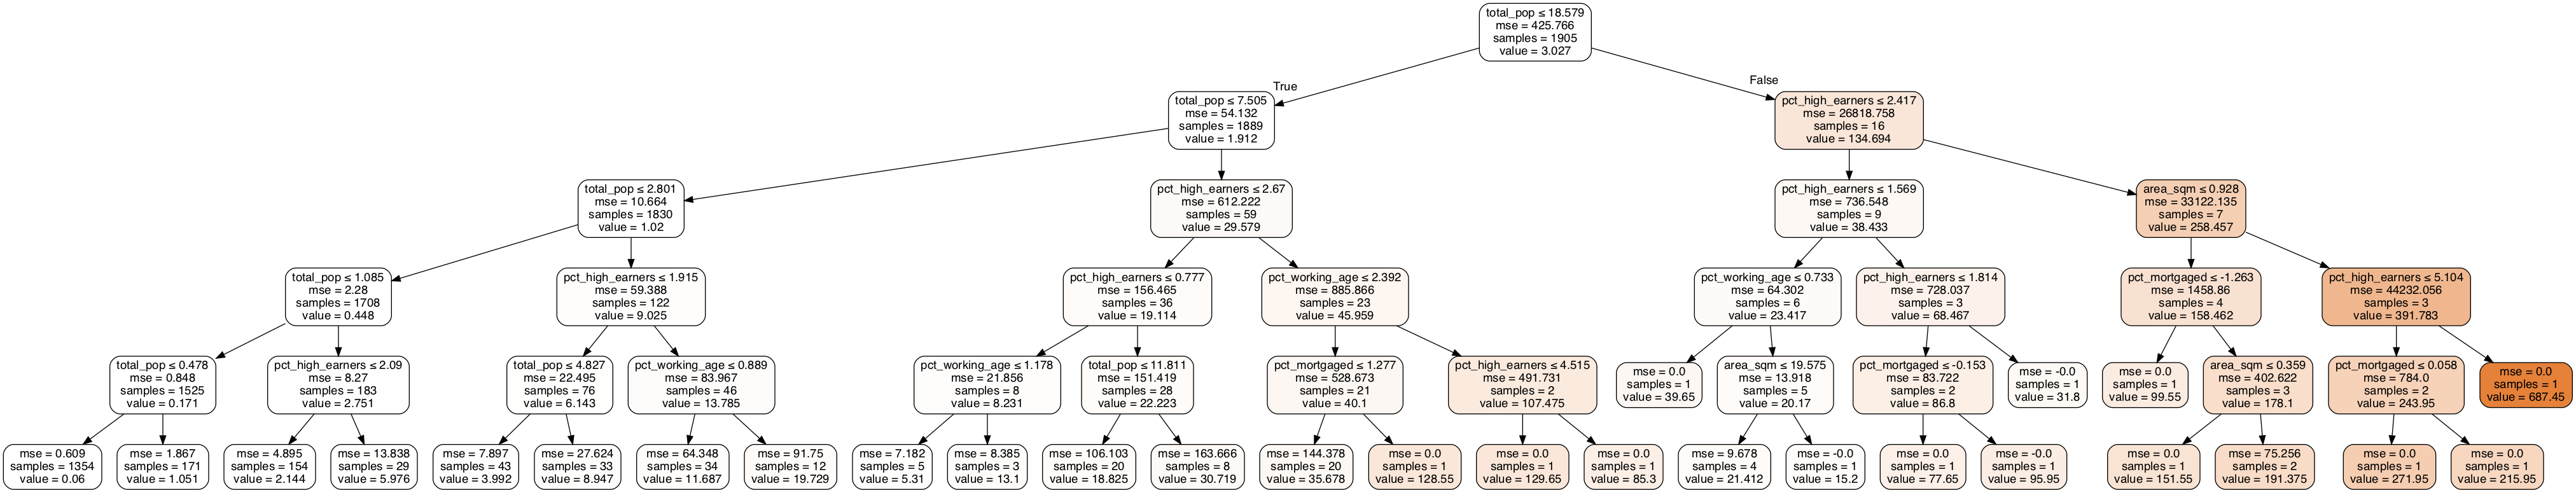

In [29]:
feat_names = ['area_sqm', 'pct_high_earners', 'total_pop', 'pct_mortgaged', 'pct_working_age']

dtree = dt_reg

from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

dot_data = StringIO()
export_graphviz(dtree, out_file=dot_data,
                feature_names = feat_names,
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

## Decision Tree Cross Validation

In [30]:
dt_reg2 = DecisionTreeRegressor(max_depth=5)
y_pred = cross_val_predict(dt_reg2, X_opt, y_pat_out, cv=cv)
# print(accuracy_score(y.astype(int), y_pred.astype(int)))


# Compute Error measures for the TEST dataset
mse_dt = mean_squared_error(y_pat_out, y_pred)  
mae_dt = mean_absolute_error(y_pat_out, y_pred)

print(f'''mse_dt: {mse_dt}
mae_dt: {mae_dt}''')

mse_dt: 409.9695729753604
mae_dt: 3.3384009030204016


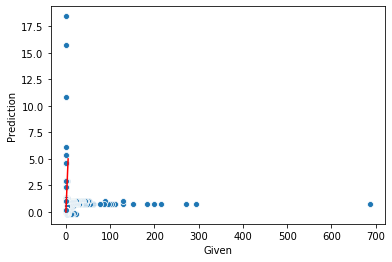

In [31]:
# plot k-fold predictions against actual
plot_k = sns.scatterplot(y_pat_out, y_pred)
plot_k.set(xlabel='Given', ylabel='Prediction')
# generate and graph y = x line
x_plot = np.linspace(0,5,100)
y_plot = x_plot
plt.plot(x_plot, y_plot, color='r')

### Baseline

Cross Validation on the baseline model

In [32]:
X_baseline = robust_scaled_df['total_pop'].values.reshape(-1, 1)

lr1 = LinearRegression()     # Create sklearn model object  
y_pred = cross_val_predict(lr1, X_baseline, y_pat_out, cv=cv)

# print(accuracy_score(y.astype(int), y_pred.astype(int)))

# Compute Error measures for the TEST dataset
mse_lr = mean_squared_error(y_pat_out, y_pred)  
mae_lr = mean_absolute_error(y_pat_out, y_pred)

print(f'''Benchmark Cross Val mse: {mse_lr}
Benchmark Cross Val mae: {mae_lr}''')

Benchmark Cross Val mse: 426.8560546867497
Benchmark Cross Val mae: 6.1394269776835095
